<a href="https://colab.research.google.com/github/Franklingo13/PVDefectDetect/blob/main/RNA/Entrenamiento_grietasGColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook para entrenamiento de redes neuronales convolucionales para clasificación de defectos en imágenes de celdas fotovoltaicas.
Pensado para correr en Google Colab.

In [1]:
# Conexión con Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Importación de la librería de pv-vision
!pip install pv-vision

In [3]:
# Importación de librerías
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn import DataParallel
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets.vision import VisionDataset
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F

import cv2 as cv
import numpy as np

import requests
import copy
from unet_model import construct_unet
from pathlib import Path
from PIL import Image
from imutils.paths import list_images
import os

In [4]:
# Importar el manejador de modelo: ModelHandler
from pv_vision.nn import ModelHandler

In [5]:
# Definición de una clase para el conjunto de datos solar,
# que hereda de la clase VisionDataset de PyTorch.
class SolarDataset(VisionDataset):
    """Un conjunto de datos que lee directamente las imágenes y las máscaras desde una carpeta."""

    # Se definió el método de inicialización para la clase.
    def __init__(self,
                 root,
                 image_folder,
                 mask_folder,
                 transforms,
                 mode = "train",
                 random_seed=42):
        # Se llamó al método de inicialización de la clase padre.
        super().__init__(root, transforms)
        # Se establecieron las rutas a las carpetas de imágenes y máscaras.
        self.image_path = Path(self.root) / image_folder
        self.mask_path = Path(self.root) / mask_folder

        # Se verificó que las carpetas de imágenes y máscaras existan.
        if not os.path.exists(self.image_path):
            raise OSError(f"{self.image_path} no encontrado.")

        if not os.path.exists(self.mask_path):
            raise OSError(f"{self.mask_path} no encontrado.")

        # Se obtuvieron las listas de imágenes y máscaras y se ordenaron.
        self.image_list = sorted(list(list_images(self.image_path)))
        self.mask_list = sorted(list(list_images(self.mask_path)))

        # Se convirtieron las listas de imágenes y máscaras a arrays de numpy.
        self.image_list = np.array(self.image_list)
        self.mask_list = np.array(self.mask_list)

        # Se estableció la semilla para la generación de números aleatorios y se mezclaron las imágenes y las máscaras.
        np.random.seed(random_seed)
        index = np.arange(len(self.image_list))
        np.random.shuffle(index)
        self.image_list = self.image_list[index]
        self.mask_list = self.mask_list[index]

    # Se definió el método para obtener la longitud del conjunto de datos.
    def __len__(self):
        return len(self.image_list)

    # Se definió un método para obtener el nombre de una imagen o máscara.
    def __getname__(self, index):
        image_name = os.path.splitext(os.path.split(self.image_list[index])[-1])[0]
        mask_name = os.path.splitext(os.path.split(self.mask_list[index])[-1])[0]

        if image_name == mask_name:
            return image_name
        else:
            return False

    # Se definió un método para obtener una imagen y su máscara correspondiente.
    def __getraw__(self, index):
        if not self.__getname__(index):
            raise ValueError("{}: La imagen no coincide con la máscara".format(os.path.split(self.image_list[index])[-1]))
        image = Image.open(self.image_list[index])
        mask = Image.open(self.mask_list[index]).convert('L')
        mask = np.array(mask)
        mask = Image.fromarray(mask)

        return image, mask

    # Se definió el método para obtener un elemento del conjunto de datos.
    def __getitem__(self, index):
        image, mask = self.__getraw__(index)
        image, mask = self.transforms(image, mask)

        return image, mask

In [19]:
# Definición de una clase para componer varias transformaciones.
class Compose:
    def __init__(self, transforms):
        """
        transforms: una lista de transformaciones
        """
        self.transforms = transforms

    # Se definió el método para aplicar las transformaciones a la imagen y la máscara.
    def __call__(self, image, target):
        """
        image: imagen de entrada
        target: máscara de entrada
        """
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

# Se definió una clase para redimensionar la imagen y la máscara a un tamaño fijo.
class FixResize:
    # UNet requiere que el tamaño de entrada sea múltiplo de 16
    def __init__(self, size):
        self.size = size

    # Se definió el método para redimensionar la imagen y la máscara.
    def __call__(self, image, target):
        image = F.resize(image, (self.size, self.size), interpolation=transforms.InterpolationMode.BILINEAR)
        target = F.resize(target, (self.size, self.size), interpolation=transforms.InterpolationMode.NEAREST)
        return image, target

# Se definió una clase para transformar la imagen y la máscara a tensores.
class ToTensor:
    """Transforma la imagen a tensor. Escala la imagen a [0,1] float32.
    Transforma la máscara a tensor.
    """
    def __call__(self, image, target):
        image = transforms.ToTensor()(image)
        target = torch.as_tensor(np.array(target), dtype=torch.int64)
        return image, target

# Se definió una clase para transformar la imagen a tensor manteniendo el tipo original.
class PILToTensor:
    """Transforma la imagen a tensor. Mantiene el tipo original."""
    def __call__(self, image, target):
        image = F.pil_to_tensor(image)
        target = torch.as_tensor(np.array(target), dtype=torch.int64)
        return image, target

# Se definió una clase para normalizar la imagen.
class Normalize:
    def __init__(self, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        self.mean = mean
        self.std = std

    def __call__(self, image, target):
        # Verifica si la imagen es en escala de grises (1 canal) y la convierte a RGB (3 canales) si es necesario
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)  # Repite el canal existente 3 veces
        image = F.normalize(image, mean=self.mean, std=self.std)
        return image, target

In [20]:
# Ruta al directorio que contiene las imágenes y las máscaras.
root = Path(
    '/content/drive/MyDrive/Trabajo de titulación/PV_vision/Entrenamiento')

# Se definen las transformaciones a aplicar a las imágenes y las etiquetas.
transformers = Compose([FixResize(256), ToTensor(), Normalize()])
#/content/drive/MyDrive/Trabajo de titulación/PV_vision/Entrenamiento/train/annotations
#/content/drive/MyDrive/Trabajo de titulación/PV_vision/Entrenamiento/img_label_for_training/train
# Se crean los conjuntos de datos de entrenamiento, validación y prueba.
trainset = SolarDataset(root, image_folder="train/images",
        mask_folder="train/annotations", transforms=transformers)

valset = SolarDataset(root, image_folder="val/img",
        mask_folder="val/ann", transforms=transformers)

testset = SolarDataset(root, image_folder="test/img",
        mask_folder="test/ann", transforms=transformers)

# Verificación de que la carpeta haya sido establecida correctamente
print(f"El conjunto de datos de entrenamiento contiene {len(trainset)} elementos.")

El conjunto de datos de entrenamiento contiene 1012 elementos.


In [21]:
# Se define una función para crear un modelo DeepLab preentrenado.
def DeepLab_pretrained(num_classes):
    # Se carga el modelo DeepLab con una arquitectura ResNet50 preentrenada.
    deeplab = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)

    # Se reemplaza el clasificador del modelo con un nuevo clasificador DeepLabHead.
    # El nuevo clasificador tiene 2048 características de entrada y 'num_classes' características de salida.
    deeplab.classifier = DeepLabHead(2048, num_classes)

    # Se devuelve el modelo modificado.
    return deeplab

In [ ]:
# Crea una instancia del modelo U-Net con 5 canales de salida. 
# Número de canales de salida = al número de clases
unet = construct_unet(5)
# Se "envuelve" el modelo en un objeto DataParallel. 
# Esto permite que el modelo se ejecute en paralelo en múltiples GPUs, si están disponibles.
unet = DataParallel(unet)

In [22]:
# Se define el dispositivo en el que se ejecutará el modelo.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Se imprime el dispositivo utilizado.
print(f"Dispositivo utilizado: {device}")

# Se crea el modelo utilizando la función DeepLab_pretrained definida anteriormente.
# El modelo se envuelve en un objeto DataParallel para permitir el entrenamiento en múltiples GPUs si están disponibles.
model = DataParallel(DeepLab_pretrained(5))

# Se define la función de pérdida a utilizar durante el entrenamiento.
# En este caso, se utiliza la pérdida de entropía cruzada.
criterion = CrossEntropyLoss()

# Se define el optimizador a utilizar durante el entrenamiento. En este caso, se utiliza Adam con una tasa de aprendizaje de 0.01.
optimizer = Adam(model.parameters(), lr=0.01)

# Se define el programador de la tasa de aprendizaje a utilizar durante el entrenamiento.
# En este caso, se utiliza un programador de paso que disminuye la tasa de aprendizaje en un factor de 0.2 cada 5 épocas.
lr_scheduler = StepLR(optimizer, step_size=5, gamma=0.2)

Dispositivo utilizado: cuda:0


In [23]:
# Se inicializa el manejador del modelo.
# La salida se almacena en la carpeta de salida.
modelhandler = ModelHandler(
    # Se pasa el modelo que se va a entrenar.
    model=model,
    #model = unet,

    # Se especifica el nombre de la carpeta de salida.
    model_output='out',

    # Se pasan los conjuntos de datos de entrenamiento, validación y prueba.
    train_dataset=trainset,
    val_dataset=valset,
    test_dataset=testset,

    # Se especifica el tamaño del lote para el entrenamiento y la validación.
    batch_size_train=32,
    batch_size_val=32,

    # Se pasa el programador de la tasa de aprendizaje.
    lr_scheduler=lr_scheduler,

    # Se especifica el número de épocas para el entrenamiento.
    num_epochs=10,

    # Se pasa la función de pérdida y el optimizador.
    criterion=criterion,
    optimizer=optimizer,

    # Se pasa el dispositivo en el que se ejecutará el entrenamiento.
    device=device,

    # Se especifica el directorio donde se guardarán los puntos de control del modelo.
    save_dir='/content/drive/MyDrive/Trabajo de titulación/PV_vision/Entrenamiento/PuntosControl/checkpoints',

    # Se especifica el nombre del archivo de punto de control.
    save_name='/content/drive/MyDrive/Trabajo de titulación/PV_vision/Entrenamiento/PuntosControl/deeplab.pt'
)

INFO:pv_vision.nn.modelhandler:ModelHandler initialized.


In [24]:
# Se inicializa el entrenamiento del modelo.
modelhandler.train_model()

Epoch 1 / 10
----------


100%|██████████| 32/32 [01:19<00:00,  2.48s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 1
100%|██████████| 5/5 [02:07<00:00, 25.54s/it]
INFO:pv_vision.nn.modelhandler:Val epoch: 1 	Average loss: 111.4832


Loss: 0.3783 (train) | 111.4832 (val)
Epoch 2 / 10
----------


100%|██████████| 32/32 [01:14<00:00,  2.34s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 2
100%|██████████| 5/5 [00:05<00:00,  1.03s/it]
INFO:pv_vision.nn.modelhandler:Val epoch: 2 	Average loss: 0.6289


Loss: 0.1649 (train) | 0.6289 (val)
Epoch 3 / 10
----------


100%|██████████| 32/32 [01:14<00:00,  2.33s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 3
100%|██████████| 5/5 [00:05<00:00,  1.03s/it]
INFO:pv_vision.nn.modelhandler:Val epoch: 3 	Average loss: 0.6987


Loss: 0.1306 (train) | 0.6987 (val)
Epoch 4 / 10
----------


100%|██████████| 32/32 [01:14<00:00,  2.33s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 4
100%|██████████| 5/5 [00:05<00:00,  1.03s/it]
INFO:pv_vision.nn.modelhandler:Val epoch: 4 	Average loss: 0.7137


Loss: 0.1096 (train) | 0.7137 (val)
Epoch 5 / 10
----------


100%|██████████| 32/32 [01:14<00:00,  2.34s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 5
100%|██████████| 5/5 [00:05<00:00,  1.03s/it]
INFO:pv_vision.nn.modelhandler:Val epoch: 5 	Average loss: 0.5641


Loss: 0.1003 (train) | 0.5641 (val)
Epoch 6 / 10
----------


100%|██████████| 32/32 [01:14<00:00,  2.34s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 6
100%|██████████| 5/5 [00:05<00:00,  1.02s/it]
INFO:pv_vision.nn.modelhandler:Val epoch: 6 	Average loss: 0.4972


Loss: 0.0928 (train) | 0.4972 (val)
Epoch 7 / 10
----------


100%|██████████| 32/32 [01:14<00:00,  2.34s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 7
100%|██████████| 5/5 [00:05<00:00,  1.01s/it]
INFO:pv_vision.nn.modelhandler:Val epoch: 7 	Average loss: 0.5285


Loss: 0.0895 (train) | 0.5285 (val)
Epoch 8 / 10
----------


100%|██████████| 32/32 [01:14<00:00,  2.34s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 8
100%|██████████| 5/5 [00:05<00:00,  1.01s/it]
INFO:pv_vision.nn.modelhandler:Val epoch: 8 	Average loss: 0.5870


Loss: 0.0885 (train) | 0.5870 (val)
Epoch 9 / 10
----------


100%|██████████| 32/32 [01:14<00:00,  2.34s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 9
100%|██████████| 5/5 [00:05<00:00,  1.01s/it]
INFO:pv_vision.nn.modelhandler:Val epoch: 9 	Average loss: 0.4963


Loss: 0.0875 (train) | 0.4963 (val)
Epoch 10 / 10
----------


100%|██████████| 32/32 [01:14<00:00,  2.34s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 10
100%|██████████| 5/5 [00:05<00:00,  1.01s/it]
INFO:pv_vision.nn.modelhandler:Val epoch: 10 	Average loss: 0.5313


Loss: 0.0842 (train) | 0.5313 (val)


{'train': {'loss': [0.3782583598798443,
   0.16494650331881677,
   0.13056544591433447,
   0.10956556762277844,
   0.10028134943114911,
   0.0927873694672886,
   0.08946803391804337,
   0.0884781297841091,
   0.08754022490130112,
   0.08418355469882724]},
 'val': {'loss': [111.48318314090852,
   0.6289276903675448,
   0.6987484693527222,
   0.7136992989047881,
   0.5641312341536245,
   0.4972194738926426,
   0.5285360715081615,
   0.5870297008945096,
   0.4963371607565111,
   0.5312513086103624]}}

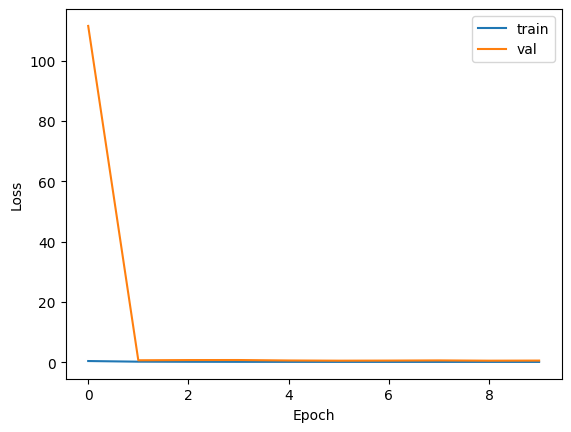

In [25]:
# Se visualiza el proceso de entrenamiento.
# Esta función traza la pérdida del modelo durante el entrenamiento.
modelhandler.plot_loss()

In [26]:
# Se busca la pérdida mínima en la validación, que corresponde al mejor modelo.
# 'np.argmin' devuelve el índice de la pérdida mínima en el conjunto de validación.
# Se suma 1 porque los índices en Python comienzan en 0, pero las épocas comienzan en 1.
np.argmin(modelhandler.running_record['val']['loss'])+1

9

In [30]:
# Se carga el mejor modelo entrenado y se verifica su rendimiento en el conjunto de prueba.
# Se emplea `load_model` para cargar el modelo entrenado. Este método toma el nombre del archivo de punto de control.
modelhandler.load_model('/content/drive/MyDrive/Trabajo de titulación/PV_vision/Entrenamiento/PuntosControl/deeplab.pt')

INFO:pv_vision.nn.modelhandler:Loaded model from /content/drive/MyDrive/Trabajo de titulación/PV_vision/Entrenamiento/PuntosControl/deeplab.pt


El siguiente código prueba el modelo en el conjunto de prueba y almacena la salida en 'testset_output'. También se hace un comentario sobre la puntuación de la prueba y la puntuación de la validación.

In [31]:
# Se evalúa el modelo en el conjunto de prueba. `test_model` es una función de ModelHandler
# que evalúa el modelo en el conjunto de prueba y almacena la salida en la caché.
_ = modelhandler.test_model(cache_output='testset_output')

# La salida del modelo se almacena en self.cache['testset_output']

Testing mode
----------


100%|██████████| 11/11 [04:26<00:00, 24.21s/it]
INFO:pv_vision.nn.modelhandler:Test set: Average loss: 1.1086


Test set: Average loss: 1.1086
